### 前期

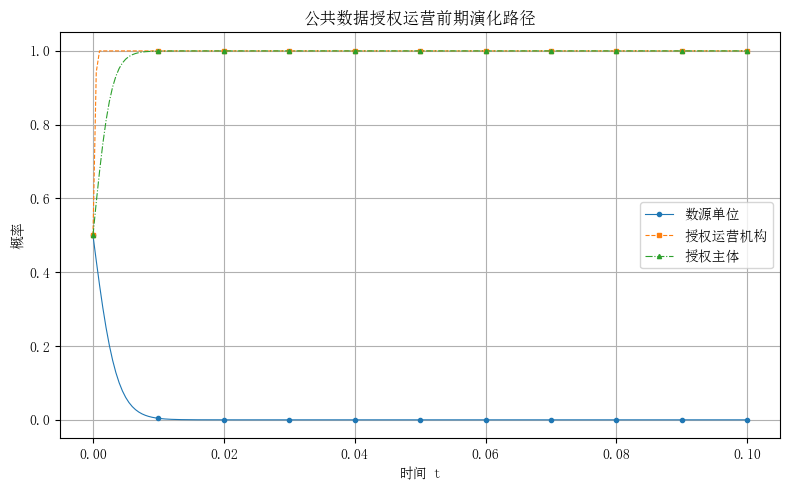

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']  # 替换为其他字体名称也可以
rcParams['axes.unicode_minus'] = False   # 防止负号显示为方块

# === 参数设置 ===

C1 = 0 # 授权运营方进行公益性服务时为获取数据所需支付的费用

# 广州市公共数据产品和服务再开发模式数据调用量超过6000万，按照0.12元为上限
# 广东省“开放广东”全省政府数据统一开放平台披露，广东省数据总开放量为27,535,772,459条，相乘得到
# 两个数据相乘，得到3304
C2 = 3304 # 授权运营方进行盈利性服务时为获取数据所需支付的费用

# 参考之前的论文内容设置P1,P2,R等参数
P1 = 413.32 # 授权运营方进行公益性服务时对数据进行加工处理的费用
P2 = 1698 # 授权运营方进行盈利性服务时对数据进行加工处理的费用
R  = 4600 # 授权方式为特许经营时，授权运营方获取授权经营凭证所需支付的费用-5520

# 按所得税税率15%计提企业所得税
g  = 0.15

# 按照C2的倍数设置U1、U2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位的实际参与成本，并根据数源单位积极消极与否更改系数
U1 = 0.4 * C2
U2 = 0.1 * C2

# 参考李海建的论文，设定公益性模式下授权运营方的收入W1为1.2R。
# 公共数据授权运营前期盈利性模式下，考虑授权运营方的成本为C2 + P2，即获取数据以及清洗数据的总成本
# 利润率设置为5%，1（成本） + 5%（利润率，不超过10年期国债平均收益率加不超过6个百分点） + 15%（所得税税率） = 1.2
# 这里没有考虑凭证费用R，是因为在前期市场主要还是以集中统一授权运营模式为主，因此不考虑R
W1 = 1.2 * R
W2 = 1.2 * (C2 + P2)

# 政府补贴主要与项目收入相关，因此此处采用授权运营方在公益性模式下的收入作为计算政府补贴的依据，并按照数源单位积极消极与否更改比例系数
# 这里没有考虑营利性模式下授权运营方的收入W2，是因为在前期，W2相对并不是很大，但是随着公共数据授权运营的不断发展，W2会越来越大，以至于影响授权运营主体的策略选择，因此最后没有考虑加入W2
L1 = 0.1 * W1
L2 = 0.05 * W1

# 考虑额外的监管成本与凭证费用R相关，并将T设置为0.9R
T = 0.9*R

# p
p = 0.2

# 按照C2的倍数设置Z1、Z2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位参与成本的节约或增加，并根据数源单位积极消极与否更改系数
# 由于数源单位积极参与的边际效益有限，但消极参与的负面影响可能极大，因此设定为积极参与的成本减少小于消极参与的成本增加，既符合现实运行逻辑，也为政策补贴设计提供了合理基础。
Z1 = 0.1 * C2
Z2 = 0.05 * C2

# k1,k2参考原来论文当中的算法
k1 = 1.1 # 当数源单位积极参与时，带来收益提升倍数
k2 = 0.9 # 当数源单位消极参与时，带来收益提升倍数

# a,b,c参考原来论文的算法
a = 0.12 # 在集中统一授权模式下分配给数源单位的收入比例
b = 1 - 0.12 - 0.12 # 在集中统一授权模式下分配给授权运营方的收入比例
c = 0.12 # 在集中统一授权模式下分配给授权运营主体的收入比例


# === 复制动态方程 ===
def Fx(x, y, z):
    return x*(1-x) * (a*z*(k1-k2)*(y*W1 + (1-y)*W2) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy(x, y, z):
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1-W2) + C2 - C1 + P2 - P1)

def Fz(x, y, z):
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1 + (1-y)*W2)*(c + g*(b-1)) - R*(1-g) + T)

# === 数值积分设置 ===
dt = 0.0005    # 时间步长
steps = 200 # 步数
t = np.linspace(0, dt*steps, steps+1)

# 初始状态
x = np.zeros(steps+1)
y = np.zeros(steps+1)
z = np.zeros(steps+1)
x[0] = 0.5
y[0] = 0.5
z[0] = 0.5

# === 欧拉法积分 ===
for i in range(steps):
    x[i+1] = x[i] + dt * Fx(x[i], y[i], z[i])
    y[i+1] = y[i] + dt * Fy(x[i], y[i], z[i])
    z[i+1] = z[i] + dt * Fz(x[i], y[i], z[i])
    
    # 限制在 [0,1] 避免数值误差越界
    x[i+1] = np.clip(x[i+1], 0, 1)
    y[i+1] = np.clip(y[i+1], 0, 1)
    z[i+1] = np.clip(z[i+1], 0, 1)

# === 绘图 ===
plt.figure(figsize=(8,5))

plt.plot(t, x, label='数源单位',
         linestyle='-', color='tab:blue',
         marker='o', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, y, label='授权运营机构',
         linestyle='--', color='tab:orange',
         marker='s', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, z, label='授权主体',
         linestyle='-.', color='tab:green',
         marker='^', markevery=20, markersize=3, linewidth = 0.8)

plt.xlabel('时间 t')
plt.ylabel('概率')
plt.title('公共数据授权运营前期演化路径')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 中期（成本考虑R，T = 0.75R）

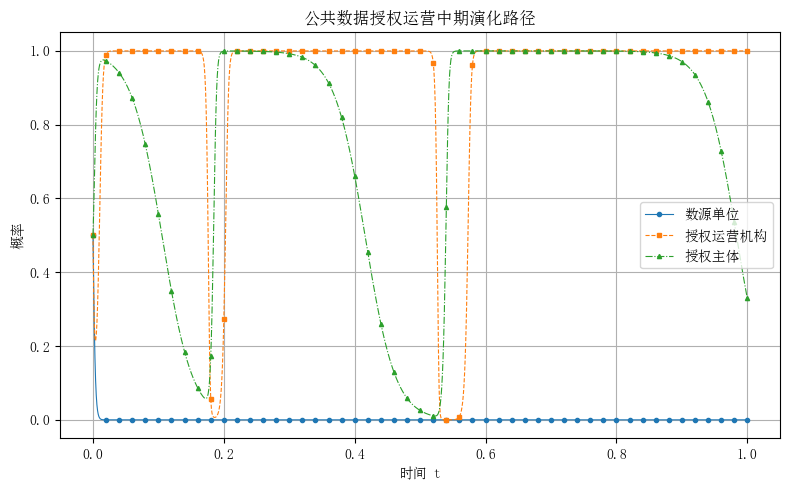

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']  # 替换为其他字体名称也可以
rcParams['axes.unicode_minus'] = False   # 防止负号显示为方块

# === 参数设置 ===

C1 = 0 # 授权运营方进行公益性服务时为获取数据所需支付的费用

# 广州市公共数据产品和服务再开发模式数据调用量超过6000万，按照0.12元为上限
# 广东省“开放广东”全省政府数据统一开放平台披露，广东省数据总开放量为27,535,772,459条，相乘得到
# 两个数据相乘，得到3304
C2 = 3304 # 授权运营方进行盈利性服务时为获取数据所需支付的费用

# 参考之前的论文内容设置P1,P2,R等参数
P1 = 413.32 # 授权运营方进行公益性服务时对数据进行加工处理的费用
P2 = 1698 # 授权运营方进行盈利性服务时对数据进行加工处理的费用
R  = 4600 # 授权方式为特许经营时，授权运营方获取授权经营凭证所需支付的费用

# 按所得税税率15%计提企业所得税
g  = 0.15

# 按照C2的倍数设置U1、U2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位的实际参与成本，并根据数源单位积极消极与否更改系数
U1 = 0.4 * C2
U2 = 0.1 * C2

# 参考李海建的论文，设定公益性模式下授权运营方的收入W1为1.2R。
# 公共数据授权运营前期盈利性模式下，考虑授权运营方的成本为C2 + P2，即获取数据以及清洗数据的总成本
# 利润率设置为5%，1（成本） + 5%（利润率，不超过10年期国债平均收益率加不超过6个百分点） + 15%（所得税税率） = 1.2
# 成本考虑凭证费用R，是因为在中后期市场慢慢向特许经营模式靠拢，因此考虑R
W1 = 1.2 * R
W2 = 1.2 * (C2 + P2 + R)

# 政府补贴主要与项目收入相关，因此此处采用授权运营方在公益性模式下的收入作为计算政府补贴的依据，并按照数源单位积极消极与否更改比例系数
# 这里没有考虑营利性模式下授权运营方的收入W2，是因为在前期，W2相对并不是很大，但是随着公共数据授权运营的不断发展，W2会越来越大，以至于影响授权运营主体的策略选择，因此最后没有考虑加入W2
L1 = 0.1 * W1
L2 = 0.05 * W1

# 考虑额外的监管成本与凭证费用R相关，并将T设置为0.75R
T = 0.75*R

# p
p = 0.2

# 按照C2的倍数设置Z1、Z2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位参与成本的节约或增加，并根据数源单位积极消极与否更改系数
# 由于数源单位积极参与的边际效益有限，但消极参与的负面影响可能极大，因此设定为积极参与的成本减少小于消极参与的成本增加，既符合现实运行逻辑，也为政策补贴设计提供了合理基础。
Z1 = 0.1 * C2
Z2 = 0.05 * C2

# k1,k2参考原来论文当中的算法
k1 = 1.1 # 当数源单位积极参与时，带来收益提升倍数
k2 = 0.9 # 当数源单位消极参与时，带来收益提升倍数

# a,b,c参考原来论文的算法
a = 0.12 # 在集中统一授权模式下分配给数源单位的收入比例
b = 1 - 0.12 - 0.12 # 在集中统一授权模式下分配给授权运营方的收入比例
c = 0.12 # 在集中统一授权模式下分配给授权运营主体的收入比例

# === 复制动态方程 ===
def Fx(x, y, z):
    return x*(1-x) * (a*z*(k1-k2)*(y*W1 + (1-y)*W2) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy(x, y, z):
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1-W2) + C2 - C1 + P2 - P1)

def Fz(x, y, z):
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1 + (1-y)*W2)*(c + g*(b-1)) - R*(1-g) + T)

# === 数值积分设置 ===
dt = 0.001    # 时间步长
steps = 1000 # 步数
t = np.linspace(0, dt*steps, steps+1)

# 初始状态
x = np.zeros(steps+1)
y = np.zeros(steps+1)
z = np.zeros(steps+1)
x[0] = 0.5
y[0] = 0.5
z[0] = 0.5

# === 欧拉法积分 ===
for i in range(steps):
    x[i+1] = x[i] + dt * Fx(x[i], y[i], z[i])
    y[i+1] = y[i] + dt * Fy(x[i], y[i], z[i])
    z[i+1] = z[i] + dt * Fz(x[i], y[i], z[i])
    
    # 限制在 [0,1] 避免数值误差越界
    x[i+1] = np.clip(x[i+1], 0, 1)
    y[i+1] = np.clip(y[i+1], 0, 1)
    z[i+1] = np.clip(z[i+1], 0, 1)

# === 绘图 ===
plt.figure(figsize=(8,5))

plt.plot(t, x, label='数源单位',
         linestyle='-', color='tab:blue',
         marker='o', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, y, label='授权运营机构',
         linestyle='--', color='tab:orange',
         marker='s', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, z, label='授权主体',
         linestyle='-.', color='tab:green',
         marker='^', markevery=20, markersize=3, linewidth = 0.8)

plt.xlabel('时间 t')
plt.ylabel('概率')
plt.title('公共数据授权运营中期演化路径')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 后期

1.C2下降了25%

2.R增长到8000

3.公共数据授权运营移出高新技术企业范围，税率恢复25%

4.成本利润率同步调整为30%（25% + 5%）

5.T = 0.6R

6.p = 0.8

7.k1 = 1.2

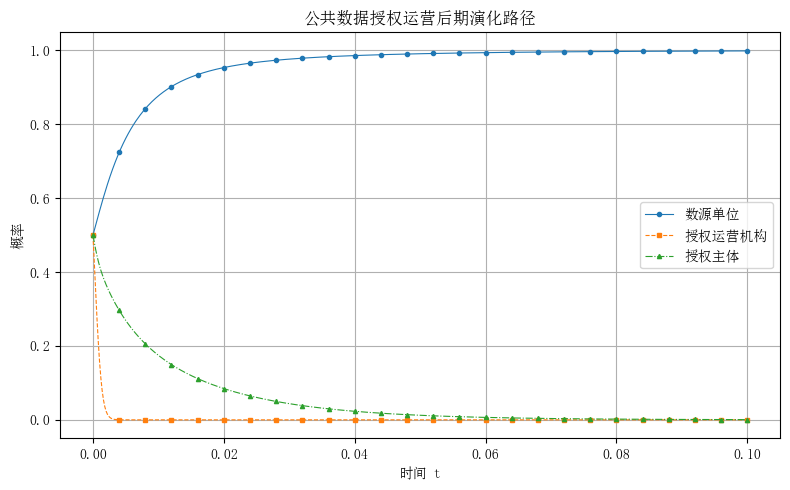

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']  # 替换为其他字体名称也可以
rcParams['axes.unicode_minus'] = False   # 防止负号显示为方块

# === 参数设置 ===

C1 = 0 # 授权运营方进行公益性服务时为获取数据所需支付的费用

# 广州市公共数据产品和服务再开发模式数据调用量超过6000万，按照0.12元为上限
# 广东省“开放广东”全省政府数据统一开放平台披露，广东省数据总开放量为27,535,772,459条，相乘得到
# 两个数据相乘，得到3304
C2 = 2478 # 授权运营方进行盈利性服务时为获取数据所需支付的费用

# 参考之前的论文内容设置P1,P2,R等参数
P1 = 413.32 # 授权运营方进行公益性服务时对数据进行加工处理的费用
P2 = 1698 # 授权运营方进行盈利性服务时对数据进行加工处理的费用
R  = 8000 # 授权方式为特许经营时，授权运营方获取授权经营凭证所需支付的费用

# 按所得税税率25%计提企业所得税
g  = 0.25

# 按照C2的倍数设置U1、U2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位的实际参与成本，并根据数源单位积极消极与否更改系数
U1 = 0.4 * C2
U2 = 0.1 * C2

# 参考李海建的论文，设定公益性模式下授权运营方的收入W1为1.2R。
# 公共数据授权运营前期盈利性模式下，考虑授权运营方的成本为C2 + P2，即获取数据以及清洗数据的总成本
# 利润率设置为5%，1（成本） + 5%（利润率，不超过10年期国债平均收益率加不超过6个百分点） + 25%（所得税税率） = 1.3 
# 成本考虑凭证费用R，是因为在中后期市场慢慢向特许经营模式靠拢，因此考虑R
W1 = 1.2 * R
W2 = 1.3 * (C2 + P2 + R)

# 政府补贴主要与项目收入相关，因此此处采用授权运营方在公益性模式下的收入作为计算政府补贴的依据，并按照数源单位积极消极与否更改比例系数
# 这里没有考虑营利性模式下授权运营方的收入W2，是因为在前期，W2相对并不是很大，但是随着公共数据授权运营的不断发展，W2会越来越大，以至于影响授权运营主体的策略选择，因此最后没有考虑加入W2
L1 = 0.1 * W1
L2 = 0.05 * W1

# 考虑额外的监管成本与凭证费用R相关，并将T设置为0.6R
T = 0.6*R

# p
p = 0.8

# 按照C2的倍数设置Z1、Z2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位参与成本的节约或增加，并根据数源单位积极消极与否更改系数
# 由于数源单位积极参与的边际效益有限，但消极参与的负面影响可能极大，因此设定为积极参与的成本减少小于消极参与的成本增加，既符合现实运行逻辑，也为政策补贴设计提供了合理基础。
Z1 = 0.1 * C2
Z2 = 0.05 * C2

# k1,k2参考原来论文当中的算法
k1 = 1.2 # 当数源单位积极参与时，带来收益提升倍数
k2 = 0.9 # 当数源单位消极参与时，带来收益提升倍数

# a,b,c参考原来论文的算法
a = 0.12 # 在集中统一授权模式下分配给数源单位的收入比例
b = 1 - 0.12 - 0.12 # 在集中统一授权模式下分配给授权运营方的收入比例
c = 0.12 # 在集中统一授权模式下分配给授权运营主体的收入比例


# === 复制动态方程 ===
def Fx(x, y, z):
    return x*(1-x) * (a*z*(k1-k2)*(y*W1 + (1-y)*W2) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy(x, y, z):
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1-W2) + C2 - C1 + P2 - P1)

def Fz(x, y, z):
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1 + (1-y)*W2)*(c + g*(b-1)) - R*(1-g) + T)

# === 数值积分设置 ===
dt = 0.0002    # 时间步长
steps = 500 # 步数
t = np.linspace(0, dt*steps, steps+1)

# 初始状态
x = np.zeros(steps+1)
y = np.zeros(steps+1)
z = np.zeros(steps+1)
x[0] = 0.5
y[0] = 0.5
z[0] = 0.5

# === 欧拉法积分 ===
for i in range(steps):
    x[i+1] = x[i] + dt * Fx(x[i], y[i], z[i])
    y[i+1] = y[i] + dt * Fy(x[i], y[i], z[i])
    z[i+1] = z[i] + dt * Fz(x[i], y[i], z[i])
    
    # 限制在 [0,1] 避免数值误差越界
    x[i+1] = np.clip(x[i+1], 0, 1)
    y[i+1] = np.clip(y[i+1], 0, 1)
    z[i+1] = np.clip(z[i+1], 0, 1)

# === 绘图 ===
plt.figure(figsize=(8,5))

plt.plot(t, x, label='数源单位',
         linestyle='-', color='tab:blue',
         marker='o', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, y, label='授权运营机构',
         linestyle='--', color='tab:orange',
         marker='s', markevery=20, markersize=3, linewidth = 0.8)

plt.plot(t, z, label='授权主体',
         linestyle='-.', color='tab:green',
         marker='^', markevery=20, markersize=3, linewidth = 0.8)

plt.xlabel('时间 t')
plt.ylabel('概率')
plt.title('公共数据授权运营后期演化路径')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 敏感度测试-数源单位

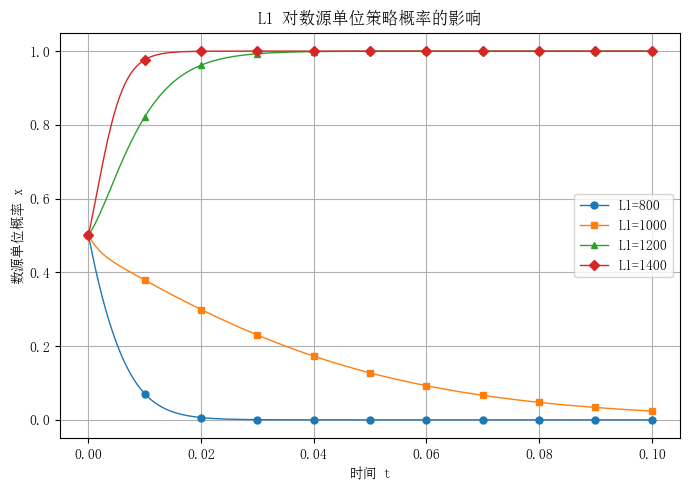

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']
rcParams['axes.unicode_minus'] = False

C1 = 0 # 授权运营方进行公益性服务时为获取数据所需支付的费用

# 广州市公共数据产品和服务再开发模式数据调用量超过6000万，按照0.12元为上限
# 广东省“开放广东”全省政府数据统一开放平台披露，广东省数据总开放量为27,535,772,459条，相乘得到
# 两个数据相乘，得到3304
C2 = 3304 # 授权运营方进行盈利性服务时为获取数据所需支付的费用

# 参考之前的论文内容设置P1,P2,R等参数
P1 = 413.32 # 授权运营方进行公益性服务时对数据进行加工处理的费用
P2 = 1698 # 授权运营方进行盈利性服务时对数据进行加工处理的费用
R  = 4600 # 授权方式为特许经营时，授权运营方获取授权经营凭证所需支付的费用-5520

# 按所得税税率15%计提企业所得税
g  = 0.15

# 按照C2的倍数设置U1、U2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位的实际参与成本，并根据数源单位积极消极与否更改系数
U1 = 0.4 * C2
U2 = 0.1 * C2

# 参考李海建的论文，设定公益性模式下授权运营方的收入W1为1.2R。
# 公共数据授权运营前期盈利性模式下，考虑授权运营方的成本为C2 + P2，即获取数据以及清洗数据的总成本
# 利润率设置为5%，1（成本） + 5%（利润率，不超过10年期国债平均收益率加不超过6个百分点） + 15%（所得税税率） = 1.2
# 这里没有考虑凭证费用R，是因为在前期市场主要还是以集中统一授权运营模式为主，因此不考虑R
W1 = 1.2 * R
W2 = 1.2 * (C2 + P2)

# 政府补贴主要与项目收入相关，因此此处采用授权运营方在公益性模式下的收入作为计算政府补贴的依据，并按照数源单位积极消极与否更改比例系数
# 这里没有考虑营利性模式下授权运营方的收入W2，是因为在前期，W2相对并不是很大，但是随着公共数据授权运营的不断发展，W2会越来越大，以至于影响授权运营主体的策略选择，因此最后没有考虑加入W2
L2 = 0.05 * W1

# 考虑额外的监管成本与凭证费用R相关，并将T设置为0.9R
T = 0.9*R

# p
p = 0.2

# 按照C2的倍数设置Z1、Z2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位参与成本的节约或增加，并根据数源单位积极消极与否更改系数
# 由于数源单位积极参与的边际效益有限，但消极参与的负面影响可能极大，因此设定为积极参与的成本减少小于消极参与的成本增加，既符合现实运行逻辑，也为政策补贴设计提供了合理基础。
Z1 = 0.1 * C2
Z2 = 0.05 * C2

# k1,k2参考原来论文当中的算法
k1 = 1.1 # 当数源单位积极参与时，带来收益提升倍数
k2 = 0.9 # 当数源单位消极参与时，带来收益提升倍数

# a,b,c参考原来论文的算法
a = 0.12 # 在集中统一授权模式下分配给数源单位的收入比例
b = 1 - 0.12 - 0.12 # 在集中统一授权模式下分配给授权运营方的收入比例
c = 0.12 # 在集中统一授权模式下分配给授权运营主体的收入比例

# === 欧拉积分参数 ===
dt = 0.0005
steps = 200
t = np.linspace(0, dt*steps, steps+1)

# === 复制动态方程 ===
def Fx_L1(x, y, z, L1):
    """数源单位复制动态方程"""
    return x*(1-x) * (a*z*(k1-k2)*(y*W1 + (1-y)*W2) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy(x, y, z):
    """授权运营方复制动态方程"""
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1-W2) + C2 - C1 + P2 - P1)

def Fz(x, y, z):
    """授权运营主体复制动态方程"""
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1 + (1-y)*W2)*(c + g*(b-1)) - R*(1-g) + T)

# === L1 参数扫描 ===
L1_values = [800, 1000, 1200, 1400]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 's', '^', 'D', 'v']

# === 绘图 ===
plt.figure(figsize=(7,5))

for idx, L1_scan in enumerate(L1_values):
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    z = np.zeros(steps+1)
    x[0] = y[0] = z[0] = 0.5

    for i in range(steps):
        x[i+1] = x[i] + dt * Fx_L1(x[i], y[i], z[i], L1_scan)
        y[i+1] = y[i] + dt * Fy(x[i], y[i], z[i])
        z[i+1] = z[i] + dt * Fz(x[i], y[i], z[i])
        # 保证在 [0,1] 内
        x[i+1] = np.clip(x[i+1], 0, 1)
        y[i+1] = np.clip(y[i+1], 0, 1)
        z[i+1] = np.clip(z[i+1], 0, 1)

    plt.plot(t, x, label=f'L1={L1_scan}', color=colors[idx],
             linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)

plt.xlabel('时间 t')
plt.ylabel('数源单位概率 x')
plt.title('L1 对数源单位策略概率的影响')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 敏感度分析-授权运营机构

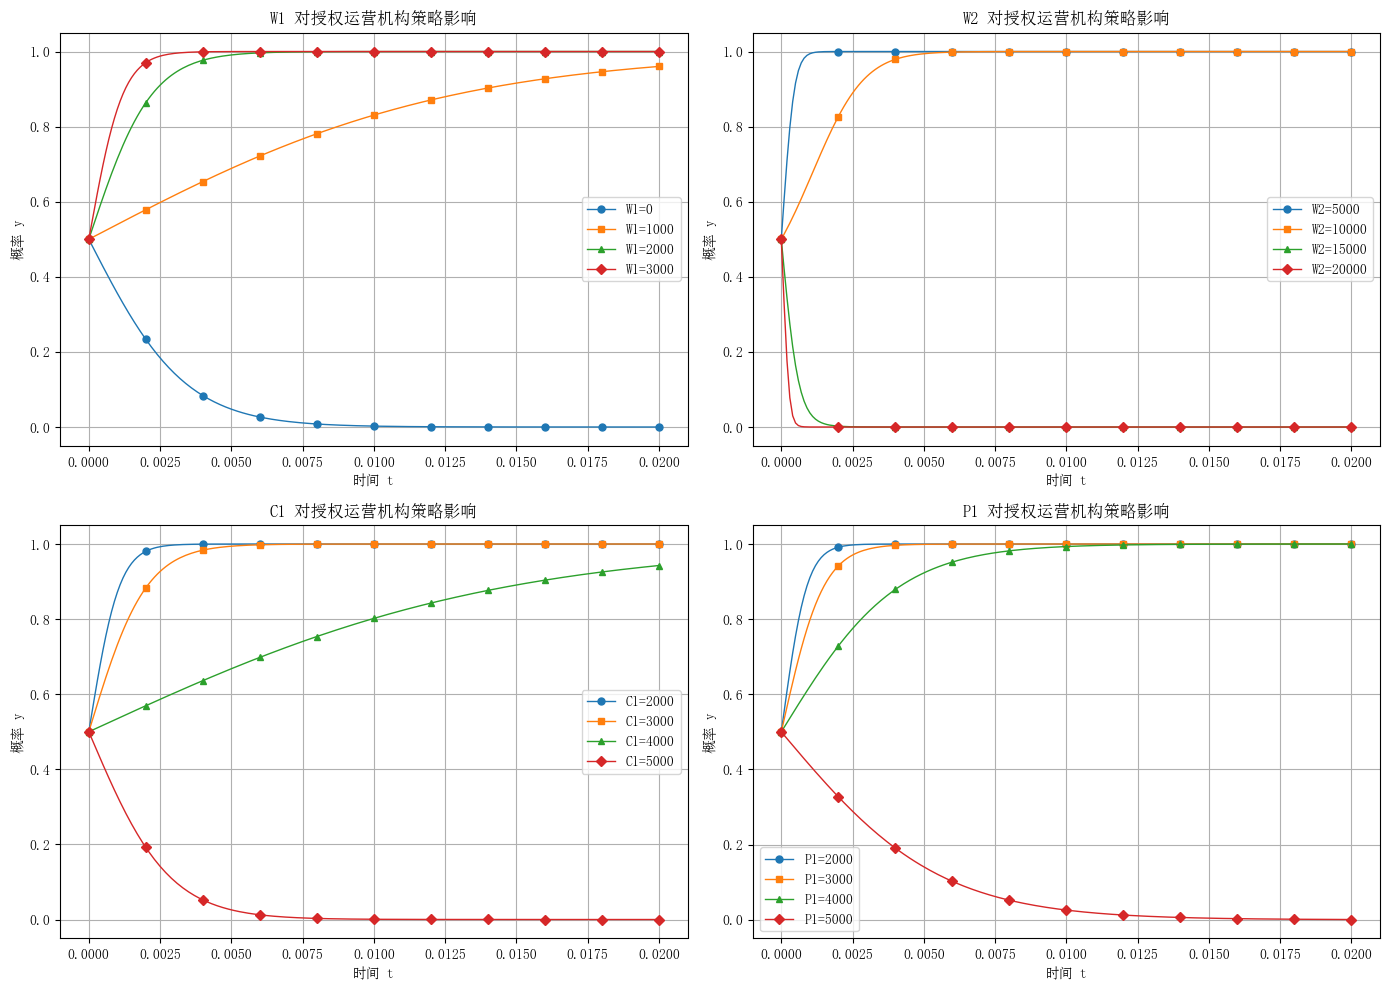

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']
rcParams['axes.unicode_minus'] = False

# === 固定参数 ===
C2 = 3304 # 授权运营方进行盈利性服务时为获取数据所需支付的费用
P2 = 1698 # 授权运营方进行盈利性服务时对数据进行加工处理的费用
R  = 4600 # 授权方式为特许经营时，授权运营方获取授权经营凭证所需支付的费用-5520

# 按所得税税率15%计提企业所得税
g  = 0.15

# 按照C2的倍数设置U1、U2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位的实际参与成本，并根据数源单位积极消极与否更改系数
U1 = 0.4 * C2
U2 = 0.1 * C2


# 考虑额外的监管成本与凭证费用R相关，并将T设置为0.9R
T = 0.9*R

# p
p = 0.2

# 按照C2的倍数设置Z1、Z2，因为盈利性模式下授权运营方为获取数据支付费用一定程度上可以反映数源单位参与成本的节约或增加，并根据数源单位积极消极与否更改系数
# 由于数源单位积极参与的边际效益有限，但消极参与的负面影响可能极大，因此设定为积极参与的成本减少小于消极参与的成本增加，既符合现实运行逻辑，也为政策补贴设计提供了合理基础。
Z1 = 0.1 * C2
Z2 = 0.05 * C2

# k1,k2参考原来论文当中的算法
k1 = 1.1 # 当数源单位积极参与时，带来收益提升倍数
k2 = 0.9 # 当数源单位消极参与时，带来收益提升倍数

# a,b,c参考原来论文的算法
a = 0.12 # 在集中统一授权模式下分配给数源单位的收入比例
b = 1 - 0.12 - 0.12 # 在集中统一授权模式下分配给授权运营方的收入比例
c = 0.12 # 在集中统一授权模式下分配给授权运营主体的收入比例

W1_fixed = 1.2*R
W2_fixed = 1.2 * (C2 + P2)
L1 = 0.1 * W1_fixed
L2 = 0.05*W1_fixed
P1_fixed = 413.32
C1_fixed = 0
x0, y0, z0 = 0.5, 0.5, 0.5

# === 欧拉积分参数 ===
dt = 0.0001
steps = 200
t = np.linspace(0, dt*steps, steps+1)

# === 复制动态方程 ===
def Fx(x, y, z):
    return x*(1-x)*(a*z*(k1-k2)*(y*W1_fixed + (1-y)*W2_fixed) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy_W(x, y, z, W_val, mode='W1'):
    if mode=='W1':
        term = (z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W_val-W2_fixed) + C2-C1_fixed + P2-P1_fixed
    elif mode=='W2':
        term = (z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1_fixed-W_val) + C2-C1_fixed + P2-P1_fixed
    return y*(1-y)*(1-g) * term

def Fy_C1(x, y, z, C1_val):
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1_fixed-W2_fixed) + C2-C1_val + P2-P1_fixed)

def Fy_P1(x, y, z, P1_val):
    return y*(1-y)*(1-g) * ((z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1_fixed-W2_fixed) + C2-C1_fixed + P2-P1_val)

def Fz(x, y, z):
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1_fixed + (1-y)*W2_fixed)*(c + g*(b-1)) - R*(1-g) + T)

# === 参数扫描值 ===
W1_values = [0, 1000, 2000, 3000]
W2_values = [5000, 10000, 15000, 20000]
C1_values = [2000, 3000, 4000, 5000]
P1_values = [2000, 3000, 4000, 5000]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 's', '^', 'D']

# === 创建四个子图 ===
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# --- 子图1：W1 ---
for idx, val in enumerate(W1_values):
    x = np.full(steps+1, x0)
    y = np.full(steps+1, y0)
    z = np.full(steps+1, z0)
    for i in range(steps):
        y[i+1] = np.clip(y[i] + dt * Fy_W(x[i], y[i], z[i], val, mode='W1'), 0, 1)
    axes[0,0].plot(t, y, label=f'W1={val}', color=colors[idx],
                   linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)
axes[0,0].set_title('W1 对授权运营机构策略影响')
axes[0,0].set_xlabel('时间 t')
axes[0,0].set_ylabel('概率 y')
axes[0,0].legend()
axes[0,0].grid(True)

# --- 子图2：W2 ---
for idx, val in enumerate(W2_values):
    x = np.full(steps+1, x0)
    y = np.full(steps+1, y0)
    z = np.full(steps+1, z0)
    for i in range(steps):
        x[i+1] = np.clip(x[i] + dt * Fx(x[i], y[i], z[i]), 0, 1)
        y[i+1] = np.clip(y[i] + dt * Fy_W(x[i], y[i], z[i], val, mode='W2'), 0, 1)
        z[i+1] = np.clip(z[i] + dt * Fz(x[i], y[i], z[i]), 0, 1)
    axes[0,1].plot(t, y, label=f'W2={val}', color=colors[idx],
                   linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)
axes[0,1].set_title('W2 对授权运营机构策略影响')
axes[0,1].set_xlabel('时间 t')
axes[0,1].set_ylabel('概率 y')
axes[0,1].legend()
axes[0,1].grid(True)

# --- 子图3：C1 ---
for idx, val in enumerate(C1_values):
    x = np.full(steps+1, x0)
    y = np.full(steps+1, y0)
    z = np.full(steps+1, z0)
    for i in range(steps):
        y[i+1] = np.clip(y[i] + dt * Fy_C1(x[i], y[i], z[i], val), 0, 1)
    axes[1,0].plot(t, y, label=f'C1={val}', color=colors[idx],
                   linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)
axes[1,0].set_title('C1 对授权运营机构策略影响')
axes[1,0].set_xlabel('时间 t')
axes[1,0].set_ylabel('概率 y')
axes[1,0].legend()
axes[1,0].grid(True)

# --- 子图4：P1 ---
for idx, val in enumerate(P1_values):
    x = np.full(steps+1, x0)
    y = np.full(steps+1, y0)
    z = np.full(steps+1, z0)
    for i in range(steps):
        y[i+1] = np.clip(y[i] + dt * Fy_P1(x[i], y[i], z[i], val), 0, 1)
    axes[1,1].plot(t, y, label=f'P1={val}', color=colors[idx],
                   linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)
axes[1,1].set_title('P1 对授权运营机构策略影响')
axes[1,1].set_xlabel('时间 t')
axes[1,1].set_ylabel('概率 y')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

### 敏感度分析-授权主体

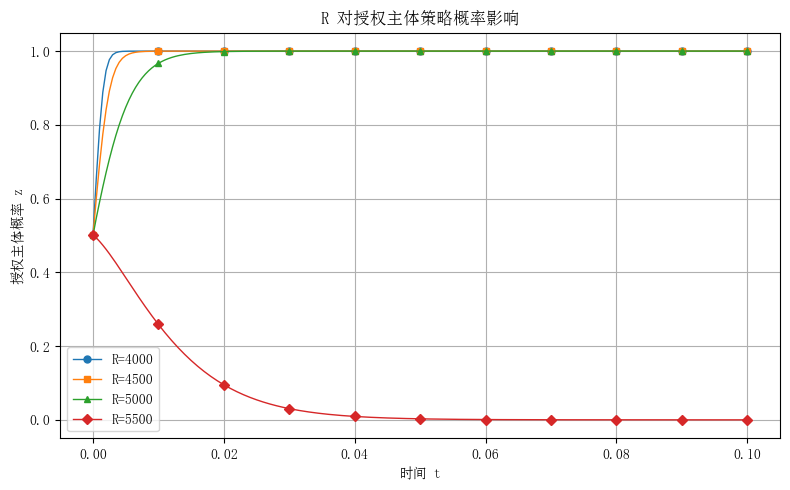

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.sans-serif'] = ['SimSun']
rcParams['axes.unicode_minus'] = False

# === 固定参数 ===
C1, C2 = 0, 3304
P1, P2 = 413.32, 1698
g = 0.15
U1, U2 = 0.4 * C2, 0.1 * C2
W1, W2 = 1.2 * 4600, 1.2 * (C2 + P2)
p = 0.2
Z1, Z2 = 0.1 * C2, 0.05 * C2
k1, k2 = 1.1, 0.9
a, b, c = 0.12, 0.76, 0.12
T = 0.9 * 4600
L1, L2 = 0.1 * W1, 0.05 * W1


# === 欧拉积分参数 ===
dt = 0.0005
steps = 200
t = np.linspace(0, dt*steps, steps+1)

# === 复制动态方程 ===
def Fx(x, y, z):
    return x*(1-x) * (a*z*(k1-k2)*(y*W1 + (1-y)*W2) + L1 - L2 + p*(Z1+Z2) - U1 + U2)

def Fy(x, y, z):
    term = (z*x*b*k1 + z*(1-x)*b*k2 + (1-z)*x*k1 + (1-z)*(1-x)*k2)*(W1-W2) + C2 - C1 + P2 - P1
    return y*(1-y)*(1-g) * term

def Fz(x, y, z, R_scan):
    return z*(1-z) * ((x*k1 + (1-x)*k2)*(y*W1 + (1-y)*W2)*(c + g*(b-1)) - R_scan*(1-g) + T)

# === R 灵敏度分析 ===
# 选择覆盖临界区间的 4 个典型值
R_values = [4000, 4500, 5000, 5500]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(8,5))

for idx, R_scan in enumerate(R_values):
    # 初始状态
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    z = np.zeros(steps+1)
    x[0] = y[0] = z[0] = 0.5

    # 欧拉法积分
    for i in range(steps):
        x[i+1] = x[i] + dt * Fx(x[i], y[i], z[i])
        y[i+1] = y[i] + dt * Fy(x[i], y[i], z[i])
        z[i+1] = z[i] + dt * Fz(x[i], y[i], z[i], R_scan)

        x[i+1] = np.clip(x[i+1], 0, 1)
        y[i+1] = np.clip(y[i+1], 0, 1)
        z[i+1] = np.clip(z[i+1], 0, 1)

    plt.plot(t, z, label=f'R={R_scan}', color=colors[idx],
             linestyle='-', marker=markers[idx], markevery=20, markersize=5, linewidth=1)

plt.xlabel('时间 t')
plt.ylabel('授权主体概率 z')
plt.title('R 对授权主体策略概率影响')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()